# MNIST FNN Neural Network

In this notebook:

1. **Load** the MNIST dataset  
2. **Preprocess** (normalize, reshape, one-hot encode, shuffle & split)  
3. **Train** with mini-batch SGD  
4. **Visualize** a few test predictions  

In [1]:
#Imports
import sys, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

root = Path.cwd().parent.resolve()
sys.path.insert(0, str(root))


from src.layers import Dense
from sklearn.datasets import fetch_openml
from src.utils  import (softmax, cross_entropy_loss, softmax_ce_gradient)

project_root = Path.cwd().parent          
sys.path.append(str(project_root))


In [2]:
def load_preprocess_mnist():
    mnist = fetch_openml('mnist_784', version=1)
    X_raw = mnist.data.to_numpy().astype(np.float32)   # (70000, 784)
    y_raw = mnist.target.to_numpy().astype(int)        # (70000,)

    # Normalize to [0,1]
    X_norm = X_raw / 255.0

    # One-hot encode labels into (70000, 10)
    num_classes = 10
    I = np.eye(num_classes)
    Y_onehot = I[y_raw]                                # (70000, 10)

    # Shuffle dataset
    n_total = X_norm.shape[0]
    perm = np.random.permutation(n_total)
    X_shuf = X_norm[perm]      # (70000, 784)
    Y_shuf = Y_onehot[perm]    # (70000, 10)

    # Split: 60k train+val, 10k test
    n_train_val = 60000
    X_train_val = X_shuf[:n_train_val]  # (60000, 784)
    Y_train_val = Y_shuf[:n_train_val]  # (60000, 10)
    X_test = X_shuf[n_train_val:]       # (10000, 784)
    Y_test = Y_shuf[n_train_val:]       # (10000, 10)

    # Further split train_val into 5k val, 55k train
    n_val = 5000
    X_val = X_train_val[:n_val]         # (5000, 784)
    Y_val = Y_train_val[:n_val]         # (5000, 10)
    X_train = X_train_val[n_val:]       # (55000, 784)
    Y_train = Y_train_val[n_val:]       # (55000, 10)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [3]:
def visualize_samples(layer1: Dense, layer2: Dense, X_test: np.ndarray, Y_test: np.ndarray, n_samples=8):
    """
    Picks n_samples at random from X_test/Y_test, runs them through the network,
    and plots the images side by side with True vs. Predicted labels.
    """
    import matplotlib.pyplot as plt

    idxs = np.random.choice(X_test.shape[0], size=n_samples, replace=False)
    X_sel = X_test[idxs]          # (n_samples, input_dim)
    Y_sel = Y_test[idxs]          # (n_samples, n_classes)

    z1 = layer1.forward(X_sel)    # (n_samples, hidden_dim)
    z2 = layer2.forward(z1)       # (n_samples, n_classes)
    probs = softmax(z2)           # (n_samples, n_classes)
    preds = np.argmax(probs, axis=1)
    true_labels = np.argmax(Y_sel, axis=1)

    plt.figure(figsize=(n_samples * 1.2, 2))
    for i in range(n_samples):
        img = X_sel[i].reshape(28, 28)
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"T:{true_labels[i]}\nP:{preds[i]}")
    plt.show()

In [4]:
def train_two_layer(
    layer1: Dense,
    layer2: Dense,
    X_train: np.ndarray,
    Y_train: np.ndarray,
    X_val: np.ndarray,
    Y_val: np.ndarray,
    num_epochs=10,
    learning_rate=0.1,
    batch_size=128,
):
    n_train = X_train.shape[0]
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, num_epochs + 1):
        perm = np.random.permutation(n_train)
        X_shuf = X_train[perm]
        Y_shuf = Y_train[perm]

        # Mini-batch loop
        for i in range(0, n_train, batch_size):
            X_batch = X_shuf[i : i + batch_size]   # (batch_size, input_dim)
            Y_batch = Y_shuf[i : i + batch_size]   # (batch_size, n_classes)

            # Forward pass
            z1 = layer1.forward(X_batch)         # (batch_size, hidden_dim), ReLU inside
            z2 = layer2.forward(z1)              # (batch_size, n_classes), linear

            probs = softmax(z2)                  # (batch_size, n_classes)

            # Backward pass
            dz2 = softmax_ce_gradient(probs, Y_batch)  # (batch_size, n_classes)
            da1 = layer2.backward(dz2)                     # (batch_size, hidden_dim)
            _   = layer1.backward(da1)                      # (batch_size, input_dim)

            # Update weights
            layer2.W -= learning_rate * layer2.dW
            layer2.b -= learning_rate * layer2.db
            layer1.W -= learning_rate * layer1.dW
            layer1.b -= learning_rate * layer1.db

        # End of epoch, compute full-train & val metrics
        z1_train = layer1.forward(X_train)
        z2_train = layer2.forward(z1_train)
        probs_train = softmax(z2_train)
        train_loss = cross_entropy_loss(probs_train, Y_train)

        z1_val = layer1.forward(X_val)
        z2_val = layer2.forward(z1_val)
        probs_val = softmax(z2_val)
        val_loss = cross_entropy_loss(probs_val, Y_val)

        preds_val = np.argmax(probs_val, axis=1)
        true_val  = np.argmax(Y_val, axis=1)
        val_acc = np.mean(preds_val == true_val)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(
            f"Epoch {epoch}/{num_epochs}  —  "
            f"train_loss: {train_loss:.4f}  —  "
            f"val_loss: {val_loss:.4f}  —  "
            f"val_acc: {val_acc:.4f}"
        )

    return history

In [5]:
def evaluate_two_layer(layer1: Dense, layer2: Dense, X_test: np.ndarray, Y_test: np.ndarray):
    """
    Runs a forward pass on the test set and returns test accuracy.
    """
    z1 = layer1.forward(X_test)          # (n_test, hidden_dim)
    z2 = layer2.forward(z1)              # (n_test, n_classes)
    probs = softmax(z2)                  # (n_test, n_classes)
    preds = np.argmax(probs, axis=1)
    true_labels = np.argmax(Y_test, axis=1)
    test_acc = np.mean(preds == true_labels)
    return test_acc

Epoch 1/10  —  train_loss: 0.3103  —  val_loss: 0.3091  —  val_acc: 0.9120
Epoch 2/10  —  train_loss: 0.2456  —  val_loss: 0.2507  —  val_acc: 0.9248
Epoch 3/10  —  train_loss: 0.2035  —  val_loss: 0.2133  —  val_acc: 0.9374
Epoch 4/10  —  train_loss: 0.1795  —  val_loss: 0.1937  —  val_acc: 0.9408
Epoch 5/10  —  train_loss: 0.1624  —  val_loss: 0.1798  —  val_acc: 0.9488
Epoch 6/10  —  train_loss: 0.1411  —  val_loss: 0.1630  —  val_acc: 0.9502
Epoch 7/10  —  train_loss: 0.1297  —  val_loss: 0.1522  —  val_acc: 0.9546
Epoch 8/10  —  train_loss: 0.1177  —  val_loss: 0.1403  —  val_acc: 0.9580
Epoch 9/10  —  train_loss: 0.1090  —  val_loss: 0.1331  —  val_acc: 0.9600
Epoch 10/10  —  train_loss: 0.1022  —  val_loss: 0.1301  —  val_acc: 0.9580
Test acc: 0.9599


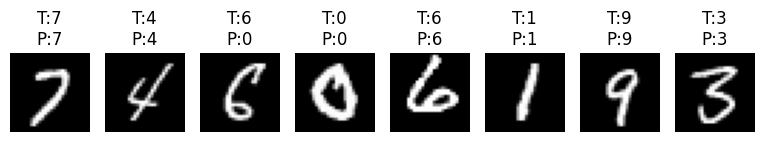

In [6]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_preprocess_mnist()

layer1 = Dense(784, 64, 'relu')
layer2 = Dense(64, 10,  'linear')

history = train_two_layer(layer1, layer2,
                          X_train, Y_train,
                          X_val,   Y_val,
                          num_epochs=10,
                          learning_rate=0.1,
                          batch_size=128)

print("Test acc:", evaluate_two_layer(layer1, layer2, X_test, Y_test))
visualize_samples(layer1, layer2, X_test, Y_test, n_samples=8)


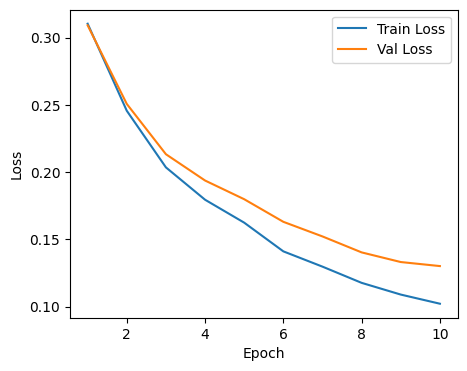

In [7]:
epochs = len(history['train_loss'])
plt.figure(figsize=(5,4))
plt.plot(range(1, epochs+1), history['train_loss'], label='Train Loss')
plt.plot(range(1, epochs+1), history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()

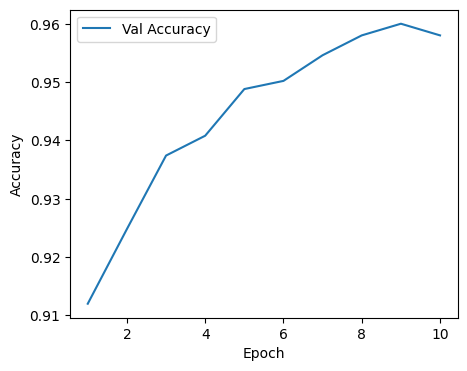

In [8]:
plt.figure(figsize=(5,4))
plt.plot(range(1, epochs+1), history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.show()
